<a href="https://colab.research.google.com/github/parment1/CAS-Advanced-Data-Science-/blob/main/project_final_14_03_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CAS ADS M6
2022-03-14
Stefan Reinhard
Thomas Parmentier

In [56]:
import numpy as np
import csv
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from keras.layers import Dropout
from keras.initializers import he_normal, normal
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import time
import platform
print (platform.machine())
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
print(f"TensorFlow version: {tf.__version__}")

x86_64
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.8.0


In [57]:
#setup data
x = []
y = []
with open('spambase.data', 'rt') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    for raw in data:
        x.append(np.array(raw[:-1], dtype=np.float32))
        y.append(int(raw[-1]))

X = np.array(x)
y = np.array(y)

#Importing columns names
colums=[]

with open('spambase.names',"r") as doc:
    lines=doc.readlines()
    for line in lines :
        colums.append(line.split(":")[0])
print(colums)

n_ch = X.shape[-1]
#normalize inputs
for ch in range(n_ch):
    ch_v = X[:, ch]
    norm = ch_v.max()
    X[:, ch] /= norm

print(X.shape, y.shape)
print(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1, stratify=y, shuffle=True)

['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capita

In [58]:
#Combined the data with labels, and check if there is any na / null

df_combined=pd.read_csv('spambase.data',names=colums)
df_describe = df_combined.describe().round(3)
print(df_combined.isna().any().any())
print(df_combined.isnull().any().any())
for col in df_combined.columns:
    print(col)

False
False
word_freq_make
word_freq_address
word_freq_all
word_freq_3d
word_freq_our
word_freq_over
word_freq_remove
word_freq_internet
word_freq_order
word_freq_mail
word_freq_receive
word_freq_will
word_freq_people
word_freq_report
word_freq_addresses
word_freq_free
word_freq_business
word_freq_email
word_freq_you
word_freq_credit
word_freq_your
word_freq_font
word_freq_000
word_freq_money
word_freq_hp
word_freq_hpl
word_freq_george
word_freq_650
word_freq_lab
word_freq_labs
word_freq_telnet
word_freq_857
word_freq_data
word_freq_415
word_freq_85
word_freq_technology
word_freq_1999
word_freq_parts
word_freq_pm
word_freq_direct
word_freq_cs
word_freq_meeting
word_freq_original
word_freq_project
word_freq_re
word_freq_edu
word_freq_table
word_freq_conference
char_freq_;
char_freq_(
char_freq_[
char_freq_!
char_freq_$
char_freq_#
capital_run_length_average
capital_run_length_longest
capital_run_length_total
class


In [59]:
#have much higher values (means = 52, 283 etc.) than most other columns which represent fraction of word occurrences (no. of times word appears in email/total no. of words in email)
df_combined.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


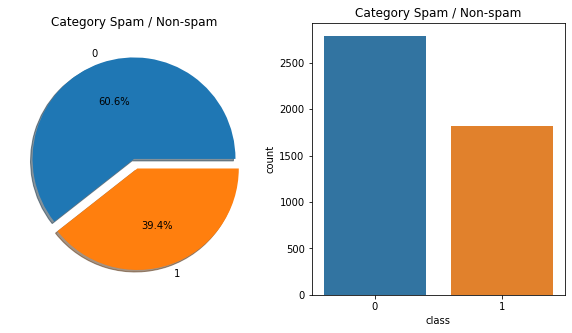

In [60]:
#To show the distribution of spam data
f,ax=plt.subplots(1,2,figsize=(10,5))
df_combined['class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Category Spam / Non-spam')
ax[0].set_ylabel('')
sns.countplot('class',data=df_combined,ax=ax[1])
ax[1].set_title('Category Spam / Non-spam')
plt.show()

[Text(0, 0.5, 'average frequency'),
 Text(0.5, 1.0, 'Non Spam minus Spam average word and char frequency')]

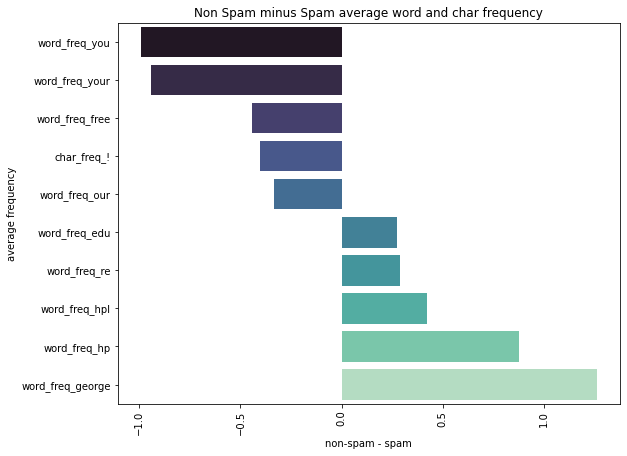

In [61]:
#chart showing the words that are the most frequent in a spam vs. the one less frenquent.
#E.g. in spams we have a lot of chars and numbers
pivot_class_freq=pd.pivot_table(df_combined,values=df_combined.drop(["class","capital_run_length_average","capital_run_length_longest","capital_run_length_total"],axis=1),index='class',aggfunc="mean")
pivot_class_freq.loc['non-spam - spam'] = pivot_class_freq.loc[0] - pivot_class_freq.loc[1]
pivot_class_freq_transposed = pivot_class_freq.T.reset_index()
pivot_class_freq_transposed.head(5)

nlargest = pivot_class_freq_transposed.nlargest(5, 'non-spam - spam')
nsmallest = pivot_class_freq_transposed.nsmallest(5, 'non-spam - spam')
df = pd.concat([nsmallest, nlargest], axis=0)
df = df.sort_values(by='non-spam - spam')

sns.color_palette("mako", as_cmap=True)
plt.figure(figsize=(9,7))
plt.xticks(rotation=90)
sns.barplot(x=df['non-spam - spam'],
            y=df['index'],
            palette="mako").set(title="Non Spam minus Spam average word and char frequency",ylabel="average frequency")

# 1 Random model

Model: "Sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 32)                1856      
                                                                 
 Layer2 (Dense)              (None, 16)                528       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


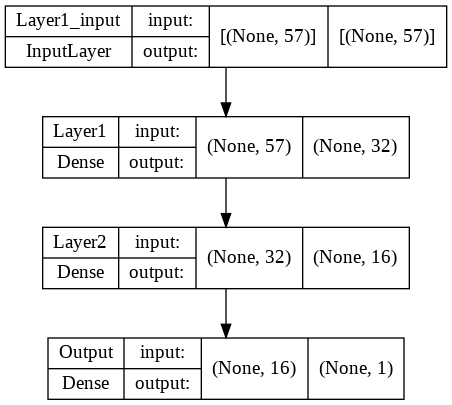

In [62]:
model = Sequential(name='Sequential_model')
model.add(Dense(32,activation='relu',name='Layer1', input_shape=(X.shape[1],)))
#model.add(Dropout(0.2))
model.add(Dense(16,activation='relu',name='Layer2'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid',name='Output'))
model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

Epoch 1/20
114/115 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.8950
Epoch 1: val_accuracy improved from -inf to 0.92725, saving model to Val_best_model.h5
115/115 [==============================] - 1s 6ms/step - loss: 0.2704 - accuracy: 0.8943 - val_loss: 0.2242 - val_accuracy: 0.9273
Epoch 2/20
114/115 [============================>.] - ETA: 0s - loss: 0.2103 - accuracy: 0.9243
Epoch 2: val_accuracy did not improve from 0.92725
115/115 [==============================] - 0s 4ms/step - loss: 0.2122 - accuracy: 0.9236 - val_loss: 0.2542 - val_accuracy: 0.9077
Epoch 3/20
115/115 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9334
Epoch 3: val_accuracy improved from 0.92725 to 0.93160, saving model to Val_best_model.h5
115/115 [==============================] - 0s 4ms/step - loss: 0.1885 - accuracy: 0.9334 - val_loss: 0.2118 - val_accuracy: 0.9316
Epoch 4/20
113/115 [============================>.] - ETA: 0s - loss: 0.1716 - accuracy: 0.

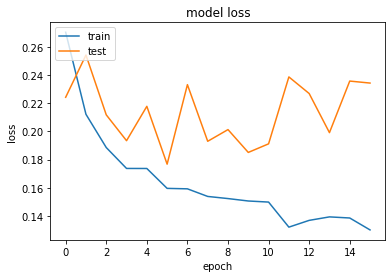

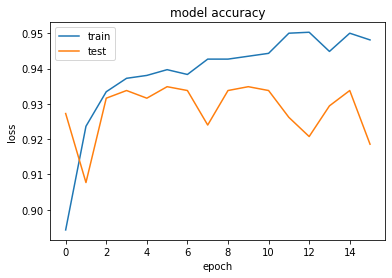

CPU times: user 7 s, sys: 452 ms, total: 7.45 s
Wall time: 7.53 s


In [64]:
%%time
mc = ModelCheckpoint('Val_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),callbacks=[es,mc])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 57)]              0         
                                                                 
 Layer1 (Dense)              (None, 32)                1856      
                                                                 
 Layer2 (Dense)              (None, 16)                528       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
115/115 [==============================] - 1s 5ms/step - loss: 0.2840 - accuracy: 0.8861 - val_loss: 0.2185 - val_accuracy: 0.9283
Epoch 2/20
115/115 [===========================

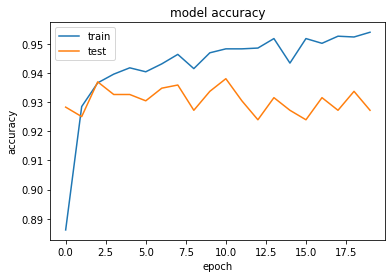

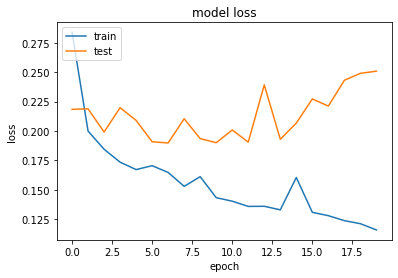

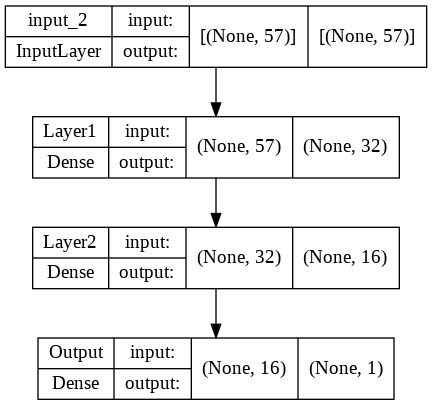

In [37]:
#functional classifier

def classifier_functional(X, M):
    N = X.shape[1]
    layer1 = Input(shape = (N, ))
    layer2 = Dense(M, activation='relu', name='Layer1')(layer1)
    layer3 = Dense(M/2, activation='relu', name='Layer2')(layer2)
    output = Dense(1, activation='sigmoid', name='Output')(layer3)
    func_model = Model(inputs =layer1, outputs=output)   
    func_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.1), metrics=['accuracy'])
    func_model.summary()
    return func_model

def Plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

M = 32
model = classifier_functional(X, M)
history = model.fit(X_train, y_train, epochs= 20, verbose=1, shuffle = False,validation_data=(X_test, y_test)) 
Plot(history)
tf.keras.utils.plot_model(model, show_shapes=True)

In [38]:
# load the saved model
saved_model = load_model('Val_best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.938, Test: 0.940


# 2 Grid search hyperparameter

## 2.1 Batch size and epochs
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [33]:
%%time
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [16,32,64,128]
epochs = [10,20, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))
grid_result1 = grid_result
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # This is added back by InteractiveShellApp.init_path()


Best: 0.941577 using {'batch_size': 64, 'epochs': 50}
0.933153 (0.003513) with: {'batch_size': 16, 'epochs': 10}
0.926087 (0.001366) with: {'batch_size': 16, 'epochs': 20}
0.930432 (0.008398) with: {'batch_size': 16, 'epochs': 50}
0.929076 (0.001752) with: {'batch_size': 16, 'epochs': 100}
0.936412 (0.003069) with: {'batch_size': 32, 'epochs': 10}
0.934782 (0.002911) with: {'batch_size': 32, 'epochs': 20}
0.927718 (0.003777) with: {'batch_size': 32, 'epochs': 50}
0.931793 (0.001696) with: {'batch_size': 32, 'epochs': 100}
0.925541 (0.006215) with: {'batch_size': 64, 'epochs': 10}
0.935053 (0.004457) with: {'batch_size': 64, 'epochs': 20}
0.941577 (0.002750) with: {'batch_size': 64, 'epochs': 50}
0.933697 (0.004048) with: {'batch_size': 64, 'epochs': 100}
0.925815 (0.006104) with: {'batch_size': 128, 'epochs': 10}
0.932064 (0.003163) with: {'batch_size': 128, 'epochs': 20}
0.937499 (0.003297) with: {'batch_size': 128, 'epochs': 50}
0.931518 (0.008733) with: {'batch_size': 128, 'epochs':

## 2.2  Optimizer

In [34]:
%%time
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
grid_result2 = grid_result
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if __name__ == '__main__':


Best: 0.932064 using {'optimizer': 'Adam'}
0.607610 (0.007325) with: {'optimizer': 'SGD'}
0.932064 (0.006056) with: {'optimizer': 'Adam'}
CPU times: user 3.66 s, sys: 264 ms, total: 3.92 s
Wall time: 16.6 s


 ## 2.3 Learning Rate



In [ ]:
%%time
def create_model(learn_rate=0.01):
    # create model
    model = Sequential()
    model.add(Dense(8,activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
learn_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train,epochs=20, batch_size=64, validation_data=(X_test, y_test))
grid_result3 = grid_result
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))

## 2.4 Tuned model

In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 3 random parameter

## 3.1 add complexity

In [ ]:
model = Sequential()
model.add(Dense(128,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3.3 increase epocs

In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

history = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3.4 decrease batch size

In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()